In [1]:
%reset -f
import glob, os, sys, inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
from wavhandler import *
from natsort import natsorted
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import io
import PIL
import seaborn as sns; sns.set()

np.random.seed(0)
plt.rcParams['figure.figsize'] = [24, 8]

import logging
logger = logging.getLogger()
logger.setLevel(logging.WARN)

def damping_ratio(freqs, ampls, peaks):
    fund_ampl = ampls[peaks[0]]
    fund_freq = freqs[peaks[0]]

    peak_a, peak_b = peaks[0], peaks[0]

    while ampls[peak_a] > fund_ampl/2:
        peak_a+=1
    while ampls[peak_b] > fund_ampl/2:
        peak_b-=1

    omega_a, omega_b = freqs[peak_a], freqs[peak_b]
    damping = (omega_a - omega_b) / (2*fund_freq)
    return damping

# Example Raw Signal

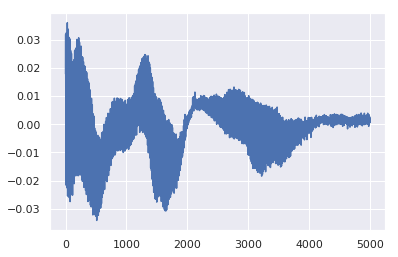

In [2]:
smpl = 1
z = WavHandler('/home/yannis/data/insects/Potamitis/Wingbeats/Aedes', sample_size=smpl, recursive=True)
z.read()
z.df_signals.iloc[:,0].plot()

# Signal after applying [75,1000] bandpass filter

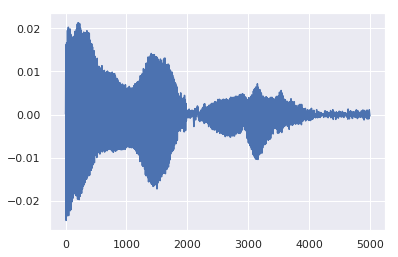

In [3]:
z.preprocess()
#z.filter_accepted_signals()
#print(len(z.accepted_signals))
z.df_signals.iloc[:,0].plot()

# Power Spectral Density (Welch's, Hamming window)

peakseries: 
 0    0.816447
Name: pows, dtype: float64
[625.]

IS THIS SIGNAL ACCEPTED? ----> False
0.075


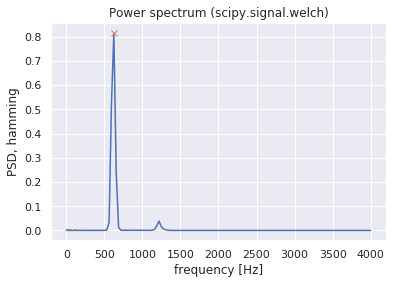

In [4]:
from sklearn.preprocessing import normalize

sig = z.df_signals.iloc[:,0]
from scipy.signal import find_peaks
f, pows = signal.welch(sig, 8000., scaling='density', window='hamming')

x = normalize(pows.reshape(-1,1), norm='l2', axis=0).reshape(-1,)
threshold = 0.1
peaks, vals = find_peaks(x, height=threshold, distance=10)
peaks = [v for i,v in enumerate(peaks) if f[peaks][i] > 300]
##############V#####
plt.plot(f,x,'-');plt.plot(f[peaks], x[peaks], "x");plt.plot(np.zeros_like(x), "--", color="gray")
plt.xlabel('frequency [Hz]');plt.ylabel('PSD, hamming');plt.title('Power spectrum (scipy.signal.welch)')

df = pd.DataFrame(np.vstack((f[peaks], x[peaks])).T, columns=['freqs','pows'])
peakseries = df['pows'].nlargest(10)
print('peakseries: \n',peakseries)
if peakseries.shape[0] == 2:
    # If there are 2 peaks, return True only if
    # the highest peak is larger than the threshold OR
    # the second highest peak is larger than the threshold
    condition = (peakseries.iloc[0] > threshold or peakseries.iloc[1] > threshold)
elif peakseries.shape[0] > 2:
    # If there are more peaks, return True if
    # the same as above AND
    # the leftmost peak is higher than the third peak (counting from the left) AND
    # the second peak from the left is also higher than the third peak
    condition = (peakseries.iloc[0] > threshold or peakseries.iloc[1] > threshold) and \
            (peakseries.loc[0] > peakseries.loc[2]) and \
            (peakseries.loc[1] > peakseries.loc[2])
else:
    condition = False
print(f[peaks])
print("\nIS THIS SIGNAL ACCEPTED? ----> {}".format(condition))

print(damping_ratio(f, x, peaks))

# Signal Cropping

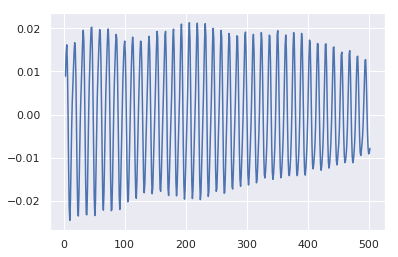

In [5]:

sigseries = pd.Series(sig)
window = 500
rolling_mean = np.abs(sigseries).rolling(window).mean()
sigseries.iloc[rolling_mean.idxmax()+1-window:rolling_mean.idxmax()+1].plot()

# Spectrogram

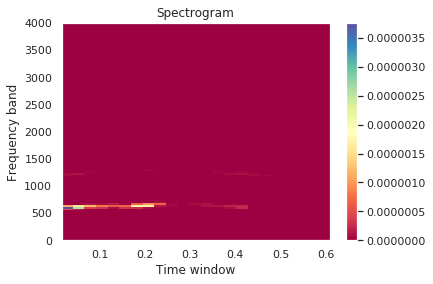

In [6]:
freqs, times, spectrogram = signal.spectrogram(sig, 8000., noverlap=50,window='hamming')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
#plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')

plt.pcolormesh(times, freqs, spectrogram, cmap='Spectral')
plt.colorbar()

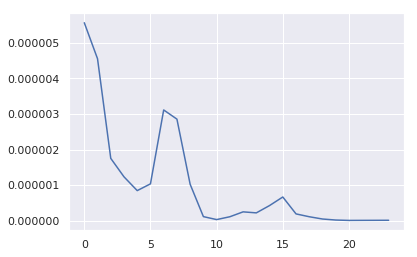

In [7]:
plt.plot(spectrogram.sum(axis=0))#, keepdims=True))


In [8]:
times, times.shape


(array([0.016  , 0.04175, 0.0675 , 0.09325, 0.119  , 0.14475, 0.1705 ,
        0.19625, 0.222  , 0.24775, 0.2735 , 0.29925, 0.325  , 0.35075,
        0.3765 , 0.40225, 0.428  , 0.45375, 0.4795 , 0.50525, 0.531  ,
        0.55675, 0.5825 , 0.60825]), (24,))

In [9]:
freqs,freqs.shape

(array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
         218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
         437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
         656.25,  687.5 ,  718.75,  750.  ,  781.25,  812.5 ,  843.75,
         875.  ,  906.25,  937.5 ,  968.75, 1000.  , 1031.25, 1062.5 ,
        1093.75, 1125.  , 1156.25, 1187.5 , 1218.75, 1250.  , 1281.25,
        1312.5 , 1343.75, 1375.  , 1406.25, 1437.5 , 1468.75, 1500.  ,
        1531.25, 1562.5 , 1593.75, 1625.  , 1656.25, 1687.5 , 1718.75,
        1750.  , 1781.25, 1812.5 , 1843.75, 1875.  , 1906.25, 1937.5 ,
        1968.75, 2000.  , 2031.25, 2062.5 , 2093.75, 2125.  , 2156.25,
        2187.5 , 2218.75, 2250.  , 2281.25, 2312.5 , 2343.75, 2375.  ,
        2406.25, 2437.5 , 2468.75, 2500.  , 2531.25, 2562.5 , 2593.75,
        2625.  , 2656.25, 2687.5 , 2718.75, 2750.  , 2781.25, 2812.5 ,
        2843.75, 2875.  , 2906.25, 2937.5 , 2968.75, 3000.  , 3031.25,
      

In [10]:
spectrogram

array([[2.03528677e-10, 1.16650532e-11, 1.46638050e-10, ...,
        2.24435649e-13, 2.37219741e-13, 2.47570163e-12],
       [1.06771396e-10, 2.01264161e-11, 2.39987072e-10, ...,
        2.50621379e-12, 2.52416699e-12, 1.14292740e-12],
       [7.48030298e-10, 3.28832640e-12, 3.42149436e-10, ...,
        4.48199877e-11, 1.64764016e-11, 1.62153618e-11],
       ...,
       [1.03178315e-13, 4.18112248e-12, 1.13408033e-15, ...,
        1.15761907e-15, 6.17999874e-15, 3.62039371e-18],
       [1.03122247e-13, 4.17900351e-12, 1.13186290e-15, ...,
        1.15680686e-15, 6.17655496e-15, 3.60757985e-18],
       [5.15517816e-14, 2.08914872e-12, 5.65561750e-16, ...,
        5.78267647e-16, 3.08770309e-15, 1.80165035e-18]])

In [11]:
spectrogram.shape

(129, 24)